In [1]:
%pip install --upgrade tensorflow[and-cuda]
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
!nvidia-smi
!python --version
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-02-27 10:20:03.433309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 10:20:03.433357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 10:20:03.434312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 10:20:03.440648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 10:20:04.157420: W tensorflow/compiler/tf2

Tue Feb 27 10:20:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.07              Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660        On  | 00000000:01:00.0  On |                  N/A |
| 46%   37C    P8               2W / 130W |    363MiB /  6144MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2024-02-27 10:20:05.717970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:05.745675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:05.745728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set the paths for training and test data
# train_data_dir = '/content/drive/MyDrive/data/train'
# val_data_dir = '/content/drive/MyDrive/data/val'

# Define the batch size and number of epochs for training
batch_size = 32
epochs = 30
num_classes = 11
# Define the input shape of the images (300 was choosen so that we can be able to use EfficientNetB2 model later on)
input_shape = (128, 128, 3)

# # train test directory
train_data_dir = 'train'
val_data_dir = 'val'
# Create data generators for training and test data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical')

Found 8806 images belonging to 11 classes.
Found 2204 images belonging to 11 classes.


In [4]:
# Define CNN model
model = Sequential()

model.add(Conv2D(32, 3, input_shape=input_shape, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Define the early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_CNN.h5', monitor='val_loss', save_best_only=True, verbose=1)


2024-02-27 10:20:06.775259: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:06.775376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:06.775413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:07.032359: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-27 10:20:07.032426: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 124, 124, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                        

In [5]:

# Train the model
history= model.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint]
        )

Epoch 1/30


2024-02-27 10:20:09.256587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-27 10:20:09.822811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-27 10:20:09.993986: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 10:20:10.890560: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 10:20:12.236353: I external/local_xla/xla/service/service.cc:168] XLA service 0x7febd61e4940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 10:20:12.236395: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 16

275/275 [==============================] - ETA: 0s - loss: 2.3660 - accuracy: 0.2804
Epoch 1: val_loss improved from inf to 2.58398, saving model to best_model_CNN.h5


/home/nguyen/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 133s 457ms/step - loss: 2.3660 - accuracy: 0.2804 - val_loss: 2.5840 - val_accuracy: 0.1415
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 1.8302 - accuracy: 0.3785
Epoch 2: val_loss improved from 2.58398 to 1.84090, saving model to best_model_CNN.h5
275/275 [==============================] - 87s 317ms/step - loss: 1.8302 - accuracy: 0.3785 - val_loss: 1.8409 - val_accuracy: 0.3575
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 1.6239 - accuracy: 0.4334
Epoch 3: val_loss improved from 1.84090 to 1.49758, saving model to best_model_CNN.h5
275/275 [==============================] - 89s 322ms/step - loss: 1.6239 - accuracy: 0.4334 - val_loss: 1.4976 - val_accuracy: 0.4472
Epoch 4/30
275/275 [==============================] - ETA: 0s - loss: 1.4885 - accuracy: 0.4692
Epoch 4: val_loss did not improve from 1.49758
275/275 [==============================] - 89s 321ms/step - loss: 1.4885 - accuracy: 0.469

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import regularizers
tf.keras.backend.clear_session()
# Create an instance of the EfficientNetB2 model
base_model = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=input_shape, pooling = 'max')

# Added a normalzation
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# Added a fully connected layer with 256 hidden units, regularizers and ReLU activation
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

# Added a dropout layer to prevent overfitting
x = Dropout(0.45, seed=123)(x)

# The final softmax layer with 8 output units
output = Dense(num_classes, activation='softmax')(x)

# created the model with the base model and the fully connected layers
model_EfficientNetV2 = Model(inputs=base_model.input, outputs=output)

# compile the model with the Adam optimizer
model_EfficientNetV2.compile(optimizer=Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('best_model_EfficientNetV2.h5', monitor='val_loss', save_best_only=True, verbose=1)
# Train the model using the train and validation generators
history_EfficientNetV2 = model_EfficientNetV2.fit(train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        callbacks=[early_stopping, model_checkpoint]
        )

Epoch 1/30


2024-02-27 11:01:09.601383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


275/275 [==============================] - ETA: 0s - loss: 5.1659 - accuracy: 0.4248
Epoch 1: val_loss improved from inf to 4.07465, saving model to best_model_EfficientNetV2.h5
275/275 [==============================] - 153s 372ms/step - loss: 5.1659 - accuracy: 0.4248 - val_loss: 4.0746 - val_accuracy: 0.5630
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 3.5919 - accuracy: 0.6119
Epoch 2: val_loss improved from 4.07465 to 3.01707, saving model to best_model_EfficientNetV2.h5
275/275 [==============================] - 99s 357ms/step - loss: 3.5919 - accuracy: 0.6119 - val_loss: 3.0171 - val_accuracy: 0.6673
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 2.7213 - accuracy: 0.6868
Epoch 3: val_loss improved from 3.01707 to 2.44233, saving model to best_model_EfficientNetV2.h5
275/275 [==============================] - 98s 356ms/step - loss: 2.7213 - accuracy: 0.6868 - val_loss: 2.4423 - val_accuracy: 0.6728
Epoch 4/30
275/275 [=============

In [10]:
#plotting the accuracy and loss of the model
import matplotlib.pyplot as plt
def plot_accuracy_loss(history,name):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy '+name)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss '+name)
    plt.savefig(name+'.png')
    plt.show()
    


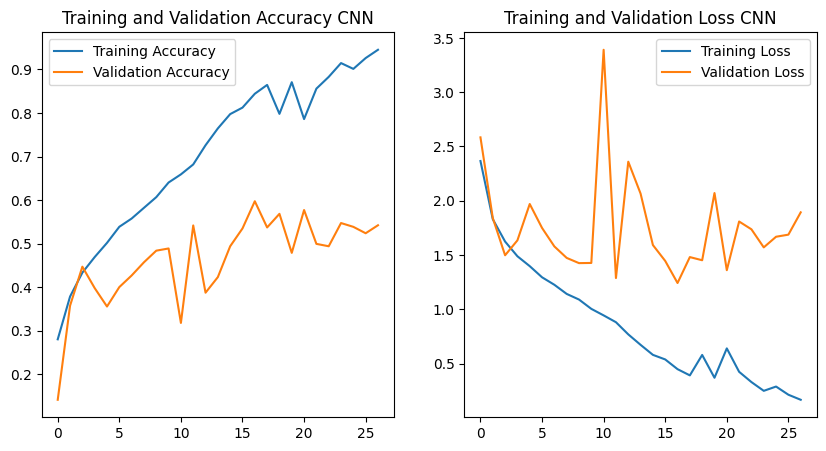

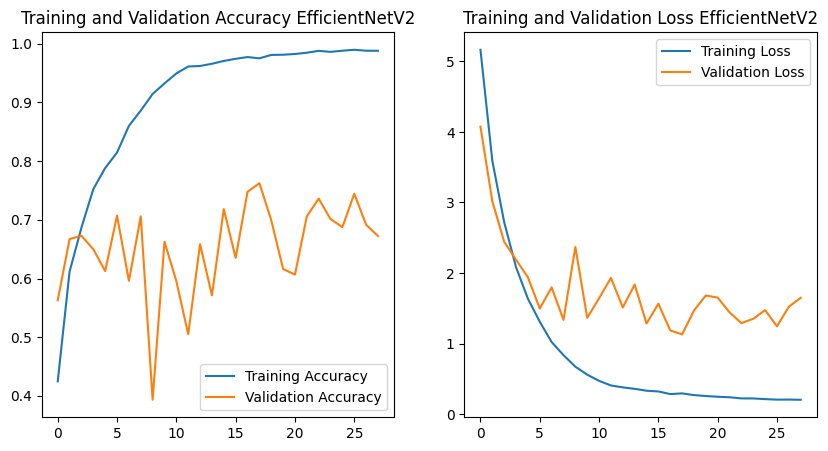

In [11]:
plot_accuracy_loss(history,"CNN")
plot_accuracy_loss(history_EfficientNetV2, "EfficientNetV2")

In [9]:
# # Save the model
# model.save('model.h5')